In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts/')
import warnings
warnings.filterwarnings('ignore')
import mlflow
from util import Util
from data_cleaner import DataCleaner
from model import Model
from preprocessor import Preprocessor
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [4]:
util = Util()
cleaner = DataCleaner()
processor = Preprocessor()

In [5]:
# read our merged train and test dataset

repo="https://github.com/Nathnael12/pharmaceutical-sales-pridiction.git"
# repo="../"

# feature_engineered_train=util.read_from_dvc("data/featured_train.csv",repo,"featured-v0",low_memory=False)

# read from local file since dvc is taking too much time
feature_engineered_train=util.read_from_file("../data/featured_train.csv") 

In [6]:
feature_engineered_train["Date"]= pd.DatetimeIndex(feature_engineered_train["Day"].astype(str)+'-' + feature_engineered_train["Month"].astype(str)+'-' + feature_engineered_train["Year"].astype(str))
feature_engineered_train.set_index('Date',inplace=True)

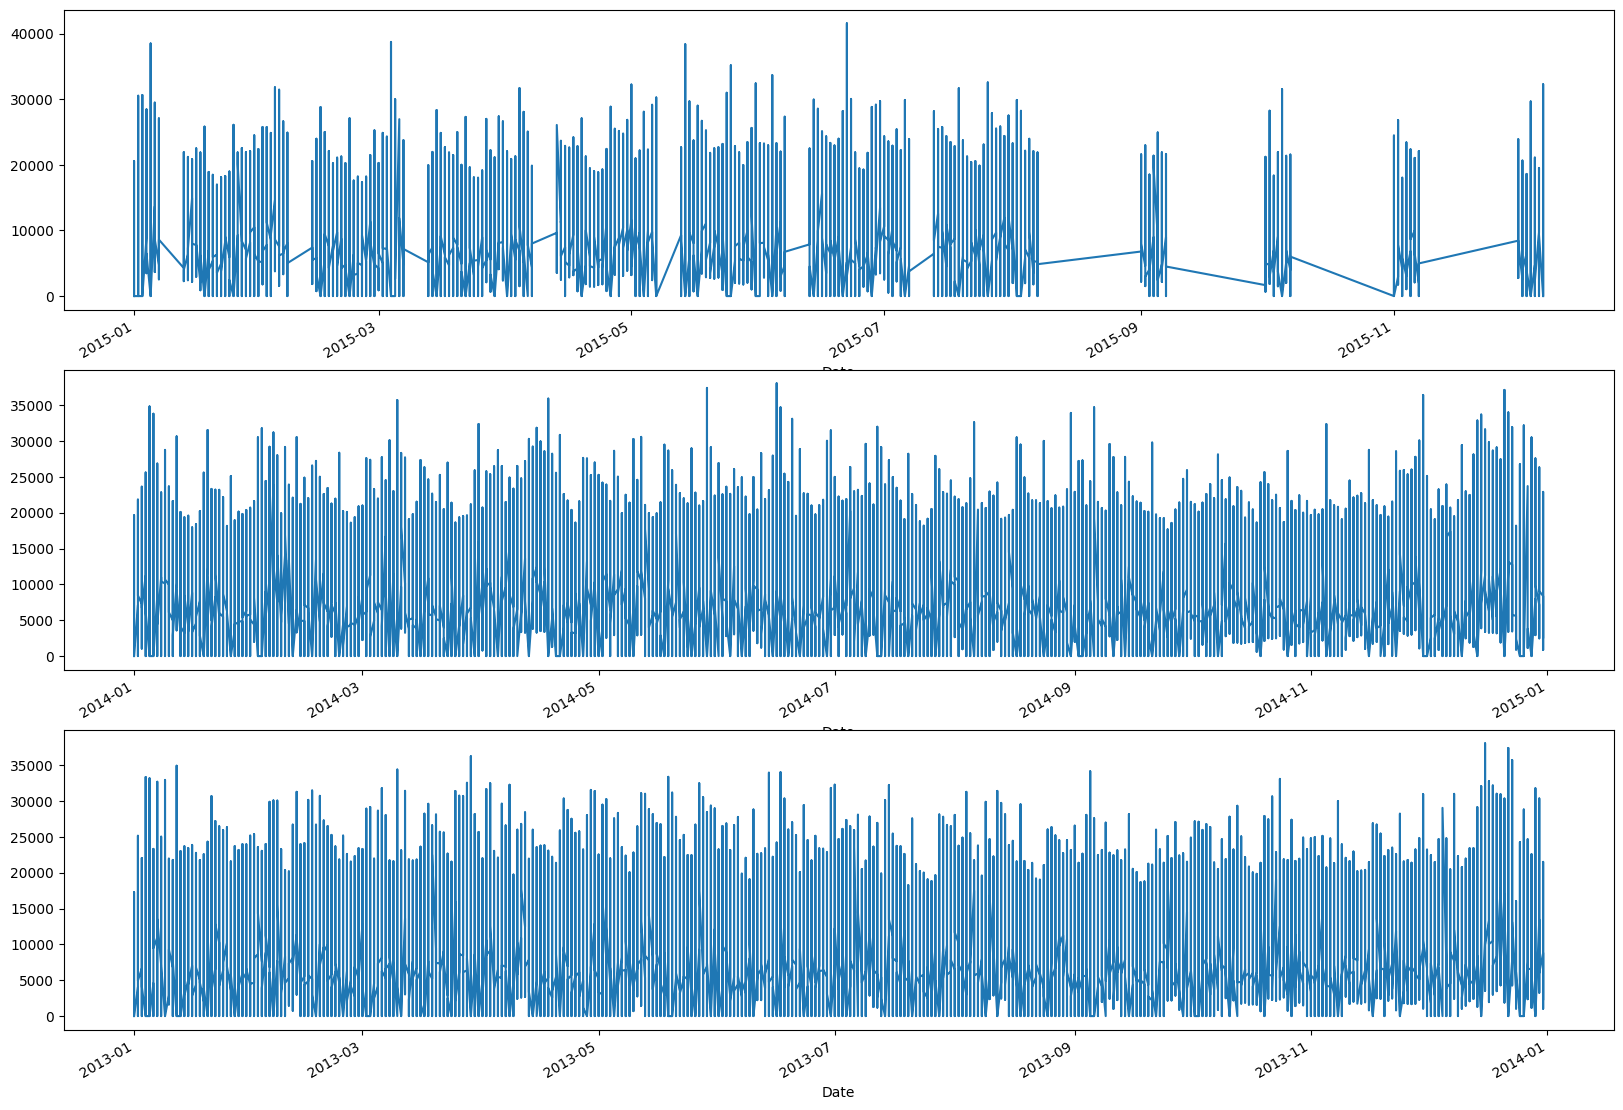

In [7]:
plt.subplots(3,1,figsize=(20,15))
plt.subplot(3,1,1)
feature_engineered_train.loc['2015']['Sales'].plot()
plt.subplot(3,1,2)
feature_engineered_train.loc['2014']['Sales'].plot()
plt.subplot(3,1,3)
feature_engineered_train.loc['2013']['Sales'].plot()
plt.show()

as seen from the above plot we havea stationary time series data (the way our data changes is uniform over time)

In [8]:
feature_engineered_train=feature_engineered_train.sort_index()

In [9]:
ny_df_final=feature_engineered_train.reset_index()[['Date','Sales']].rename({'Date':'ds','Sales':'y'}, axis='columns')

In [10]:
sales_corr=feature_engineered_train.copy()
# sales_corr["Date"]=pd.DatetimeIndex(feature_engineered_train["Day"].astype(str)+'-' + feature_engineered_train["Month"].astype(str)+'-' + feature_engineered_train["Year"].astype(str))


In [11]:
sales_lag=feature_engineered_train.groupby('Store').agg({"Sales":"sum"})

sales_corr = sales_corr.groupby('Date').agg({"Sales":"sum"})

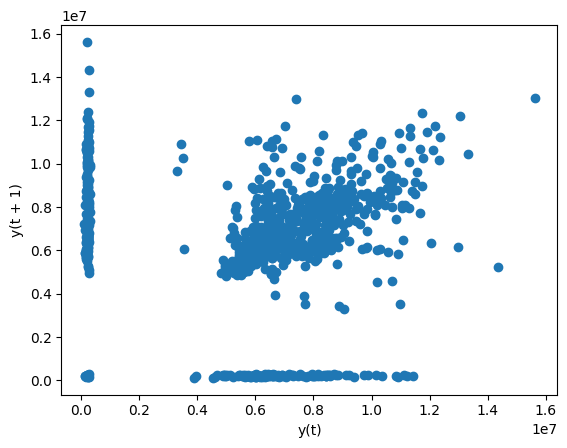

In [12]:
pd.plotting.lag_plot(sales_corr['Sales'],lag=1)
plt.show()

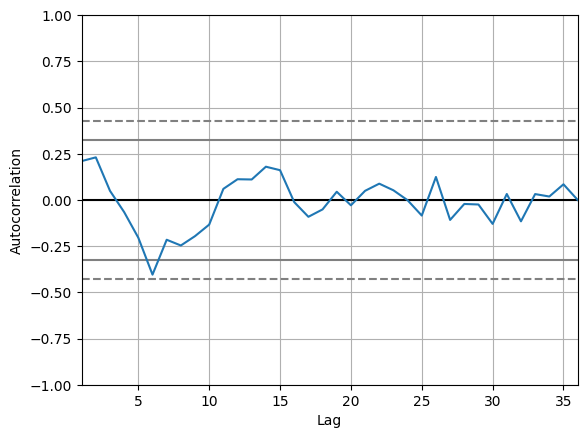

In [13]:

pd.plotting.autocorrelation_plot(sales_corr['Sales'].resample("1m").mean())
plt.show()

Based on the above plots we can see that their is  a small relationship (linear) between daily data points 

In [14]:
store_sales=feature_engineered_train[['Sales']]
store_sales.head()

,Sales
Date,
2013-01-01,0
2013-01-01,0
2013-01-01,0
2013-01-01,0
2013-01-01,0


In [15]:
scaler = MinMaxScaler()
scaler.fit(store_sales.Sales.values.reshape([-1, 1]))
houseSalesScaled = scaler.transform(store_sales.Sales.values.reshape(-1, 1))
store_sales['SalesScaled'] = houseSalesScaled
store_sales.sample(10)

,Sales,SalesScaled
Date,,
2015-07-24,5103,0.122813
2013-08-12,0,0.000000
2013-11-23,2391,0.057544
2013-09-20,4233,0.101875
2013-03-21,8008,0.192727
2014-11-17,8489,0.204303
2013-04-09,5672,0.136507
2015-01-28,9936,0.239128
2013-04-06,6905,0.166181


In [16]:
store_sales.describe()

,Sales,SalesScaled
count,1.017209e+06,1.017209e+06
mean,5.773819e+03,1.389574e-01
std,3.849926e+03,9.265544e-02
min,0.000000e+00,0.000000e+00
25%,3.727000e+03,8.969700e-02
50%,5.744000e+03,1.382398e-01
75%,7.856000e+03,1.890689e-01
max,4.155100e+04,1.000000e+00


Descriptive Statistics and Visualizations of the Data

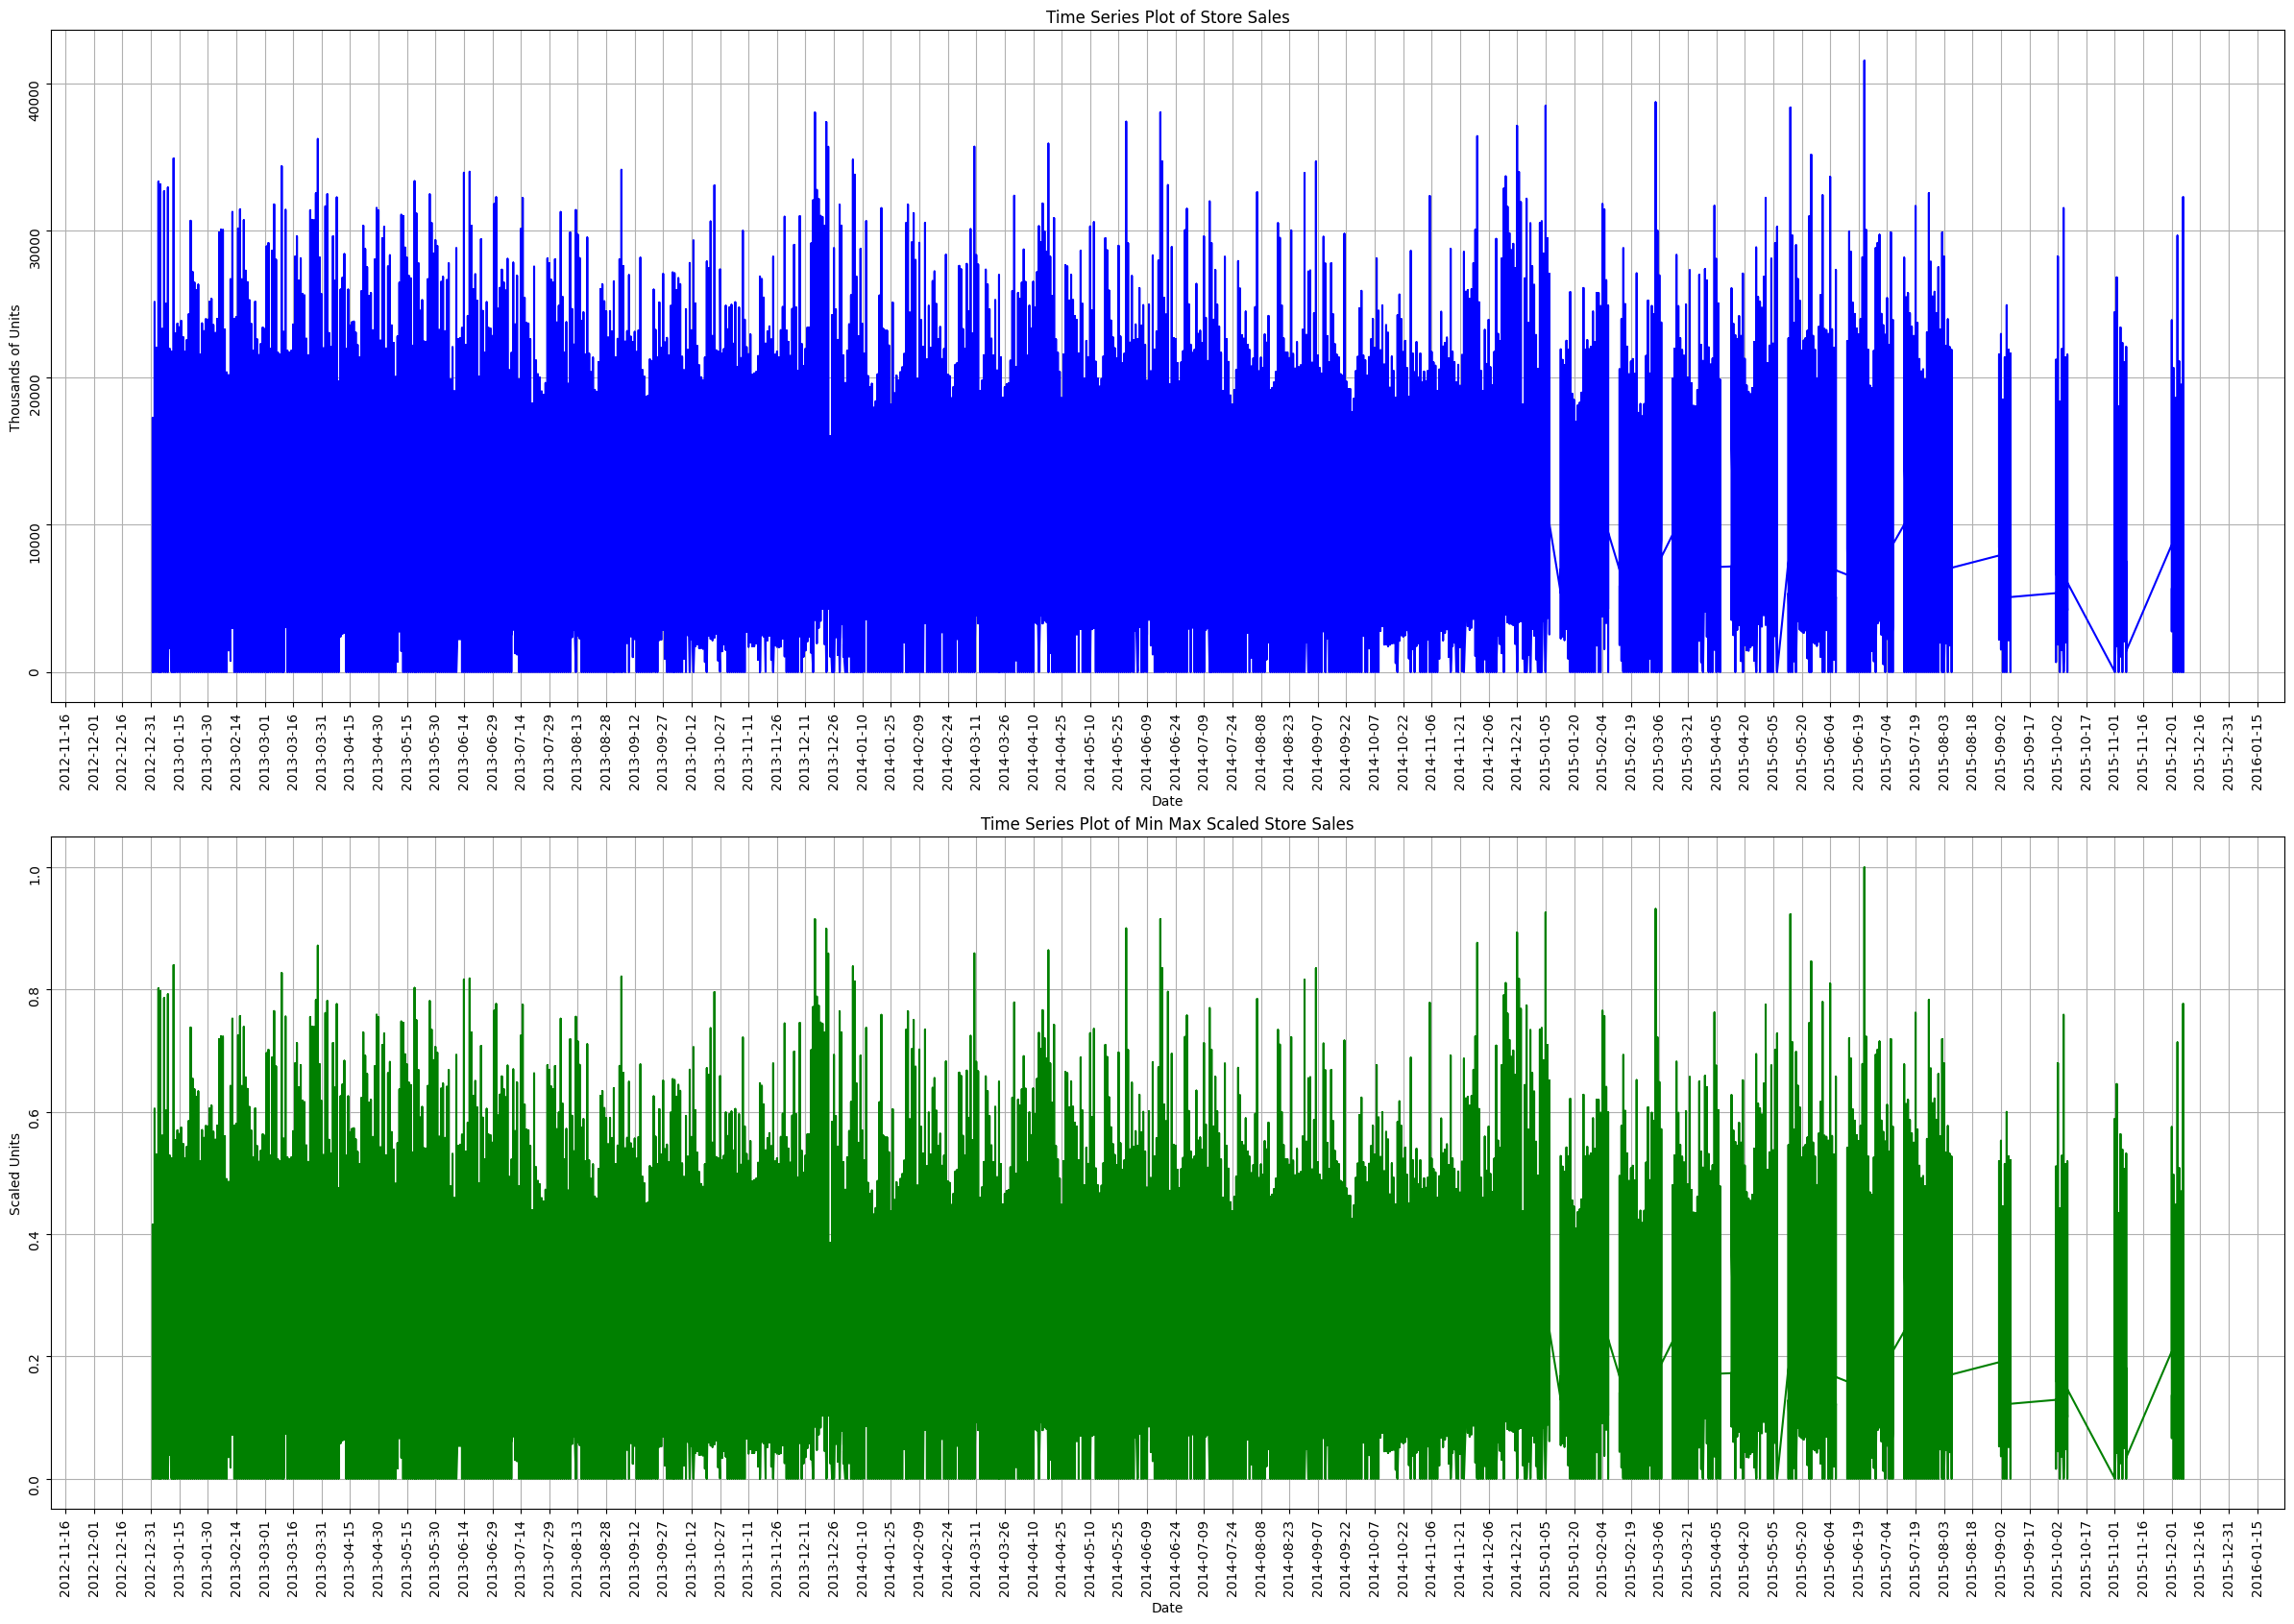

In [17]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(store_sales.index, store_sales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(store_sales.index, store_sales.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Store Sales')
ax2.grid(True)
plt.show()

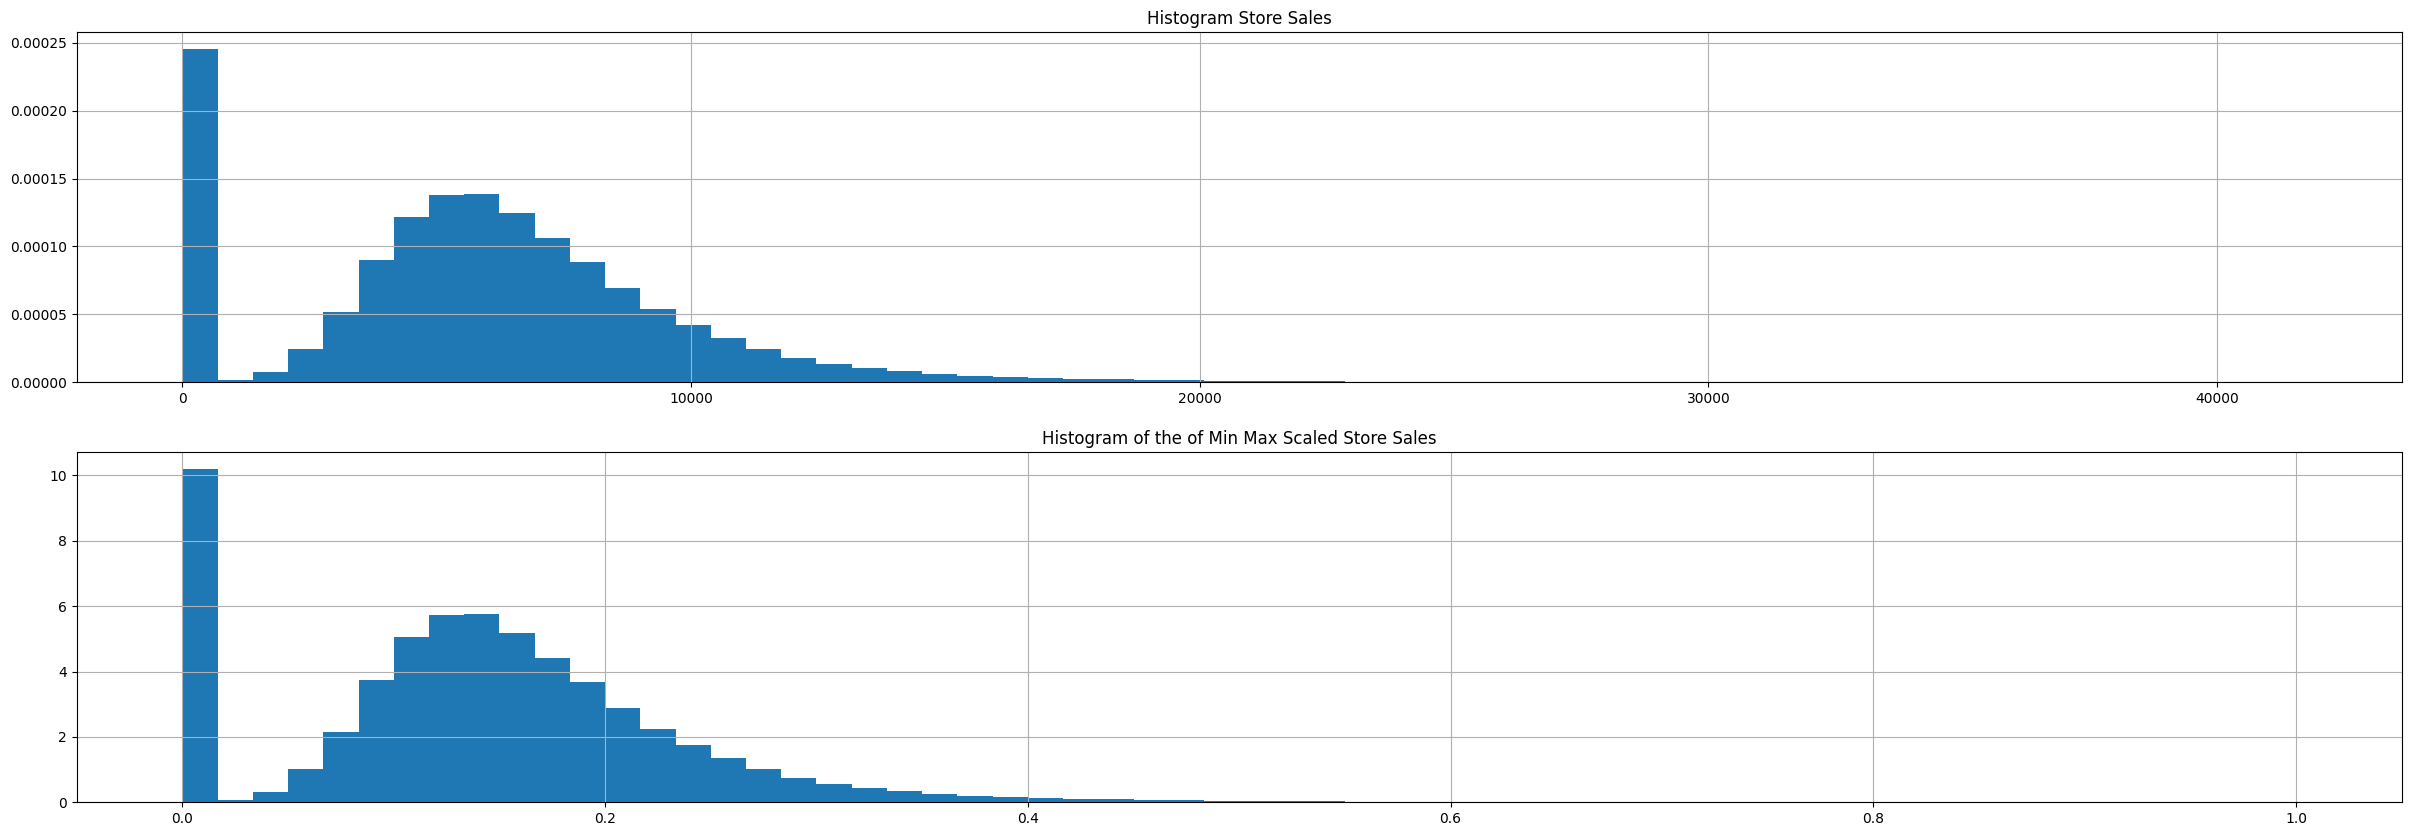

In [18]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(store_sales.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(store_sales.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Store Sales')
ax2.grid(True)
plt.show()

### Unit Root Test

In [21]:
adfResult = adfuller(store_sales.Sales.values[:50000], autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.2952673181640035
p-value: 5.600617769418529e-06


In [22]:
adfResult = adfuller(store_sales.SalesScaled.values[:50000], autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.295267318163544
p-value: 5.600617769430742e-06


Here in the results, we can see that the p-value for time series is less than 0.05, and we can reject the null hypothesis and the time series is stationary. 

### Remove stationarity

In [23]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [24]:
store_sales_dif = difference(store_sales.SalesScaled.values)

In [25]:
store_sales_dif

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1017203    0.0
1017204    0.0
1017205    0.0
1017206    0.0
1017207    0.0
Length: 1017208, dtype: float64

In [26]:
acfSalesScaled = acf(store_sales.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [31]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Store Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

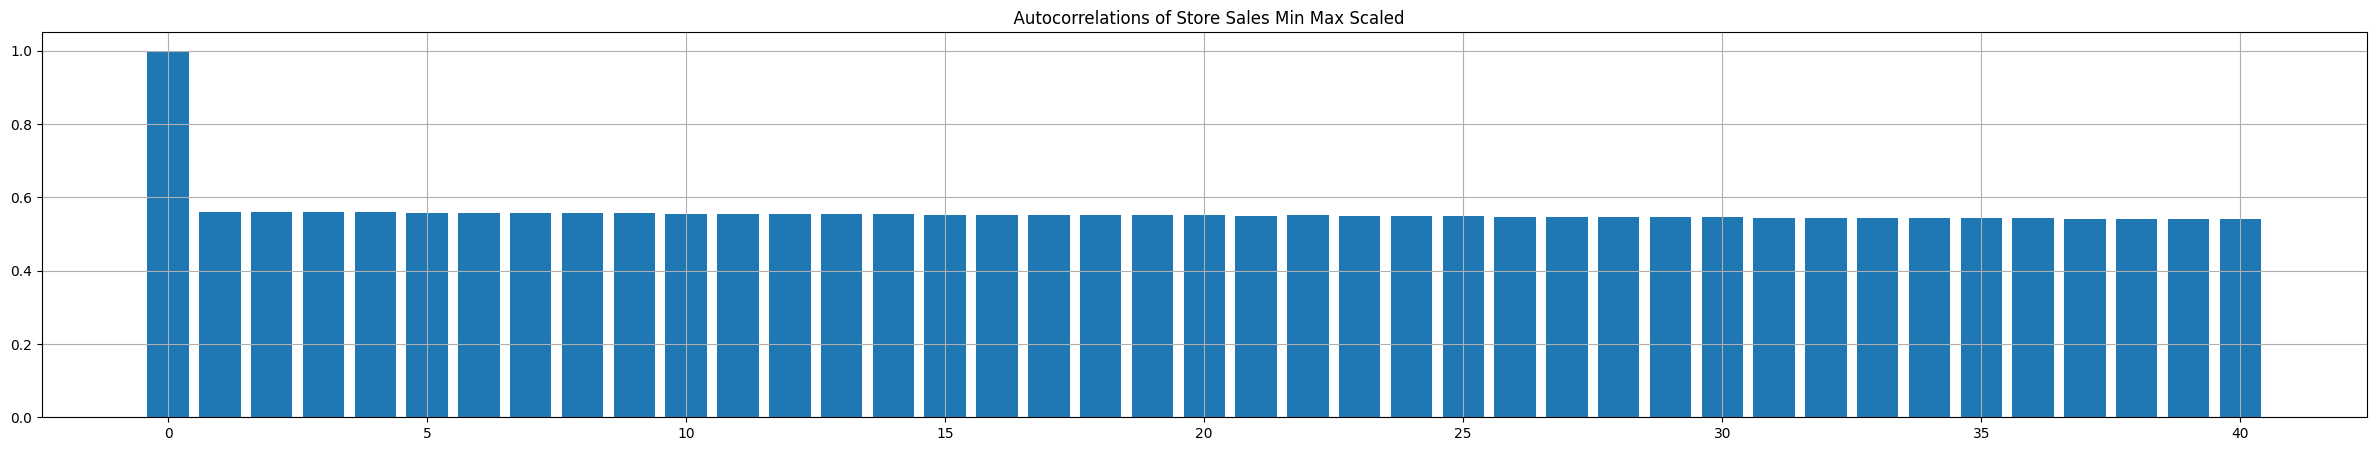

In [32]:
corrPlots(acfSalesScaledNp, '')

In [29]:
pacfSalesScaled = pacf(store_sales.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

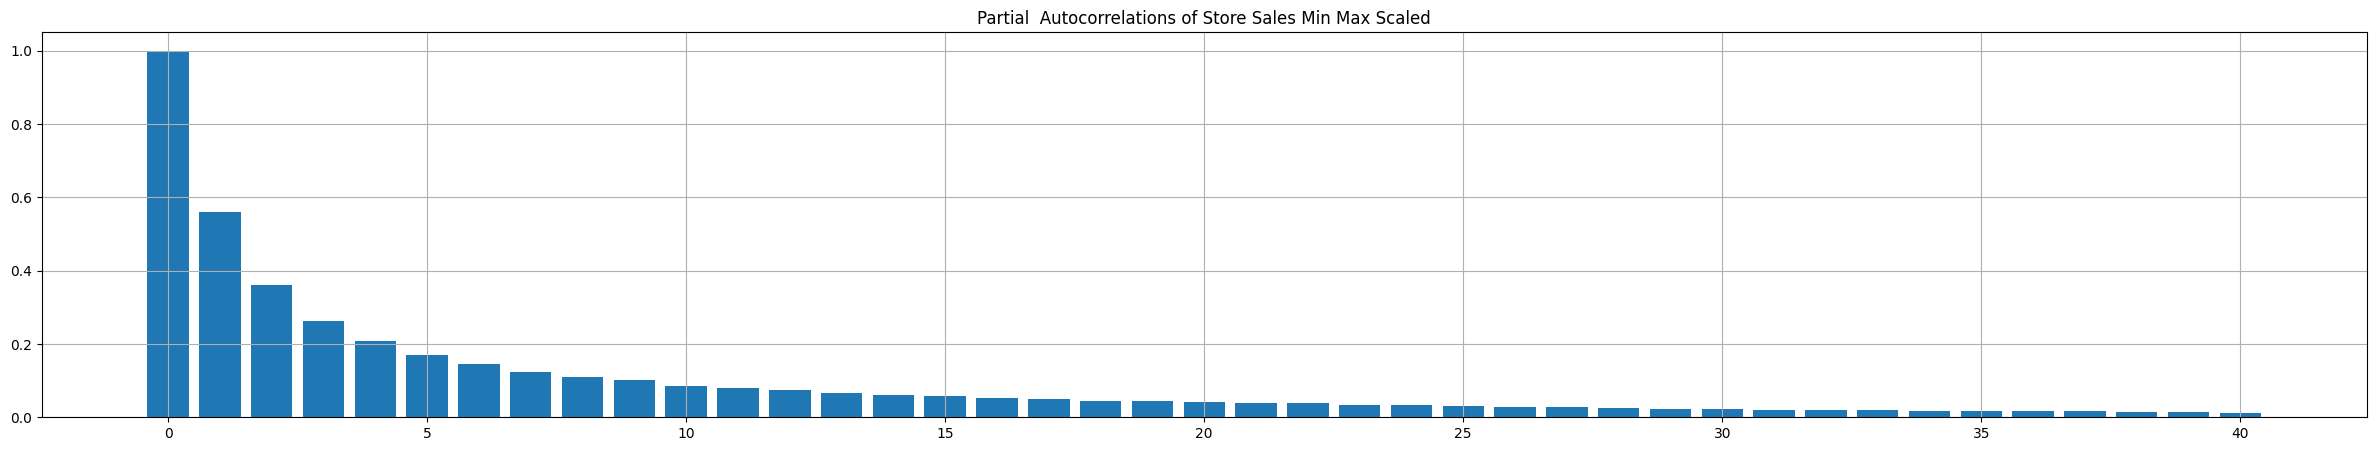

In [33]:
corrPlots(pacfSalesScaledNp, "Partial")

### Separating into a Training and validation set format to use feed into LSTM

In [72]:
store_sales_sm=store_sales.groupby('Date').agg({"Sales":"mean","SalesScaled":"mean"})

SIZE = len(store_sales_sm.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [73]:
DateTrain = store_sales_sm.index.values[0:BATCH_SIZE]
DateValid = store_sales_sm.index.values[BATCH_SIZE:]
XTrain = store_sales_sm.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = store_sales_sm.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [74]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [75]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [76]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [77]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [78]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [79]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [80]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [81]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [82]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [91]:
mlflow.set_experiment('LSTM-Forecasting')
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.start_run()

<ActiveRun: >

In [100]:
mlflow.tensorflow.autolog(every_n_iter=2)

2022/09/10 12:40:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [101]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')
# Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [102]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 8)           320       
                                                                 
 lstm_9 (LSTM)               (None, 4)                 208       
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [103]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 6s 6s/step - loss: 0.0124 - val_loss: 0.0093
Epoch 2/200
1/1 [==============================] - 0s 243ms/step - loss: 0.0113 - val_loss: 0.0084
Epoch 3/200
1/1 [==============================] - 0s 241ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 4/200
1/1 [==============================] - 0s 231ms/step - loss: 0.0094 - val_loss: 0.0067
Epoch 5/200
1/1 [==============================] - 0s 260ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 6/200
1/1 [==============================] - 0s 283ms/step - loss: 0.0076 - val_loss: 0.0052
Epoch 7/200
1/1 [==============================] - 0s 273ms/step - loss: 0.0068 - val_loss: 0.0046
Epoch 8/200
1/1 [==============================] - 0s 241ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 9/200
1/1 [==============================] - 0s 233ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 10/200
1/1 [==============================] - 0s 243ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 11/200

INFO:tensorflow:Assets written to: C:\Users\NATNAE~1.MAS\AppData\Local\Temp\tmpar569tk2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\NATNAE~1.MAS\AppData\Local\Temp\tmpar569tk2\model\data\model\assets


In [104]:
mlflow.end_run()

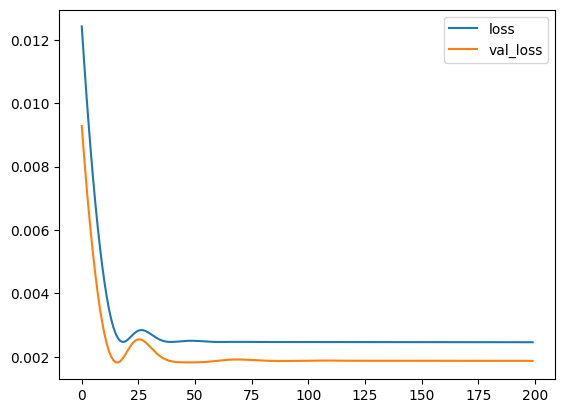

In [105]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [106]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [107]:
Forecast = model_forecast(model, store_sales_sm.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

1/1 [==============================] - 1s 1s/step


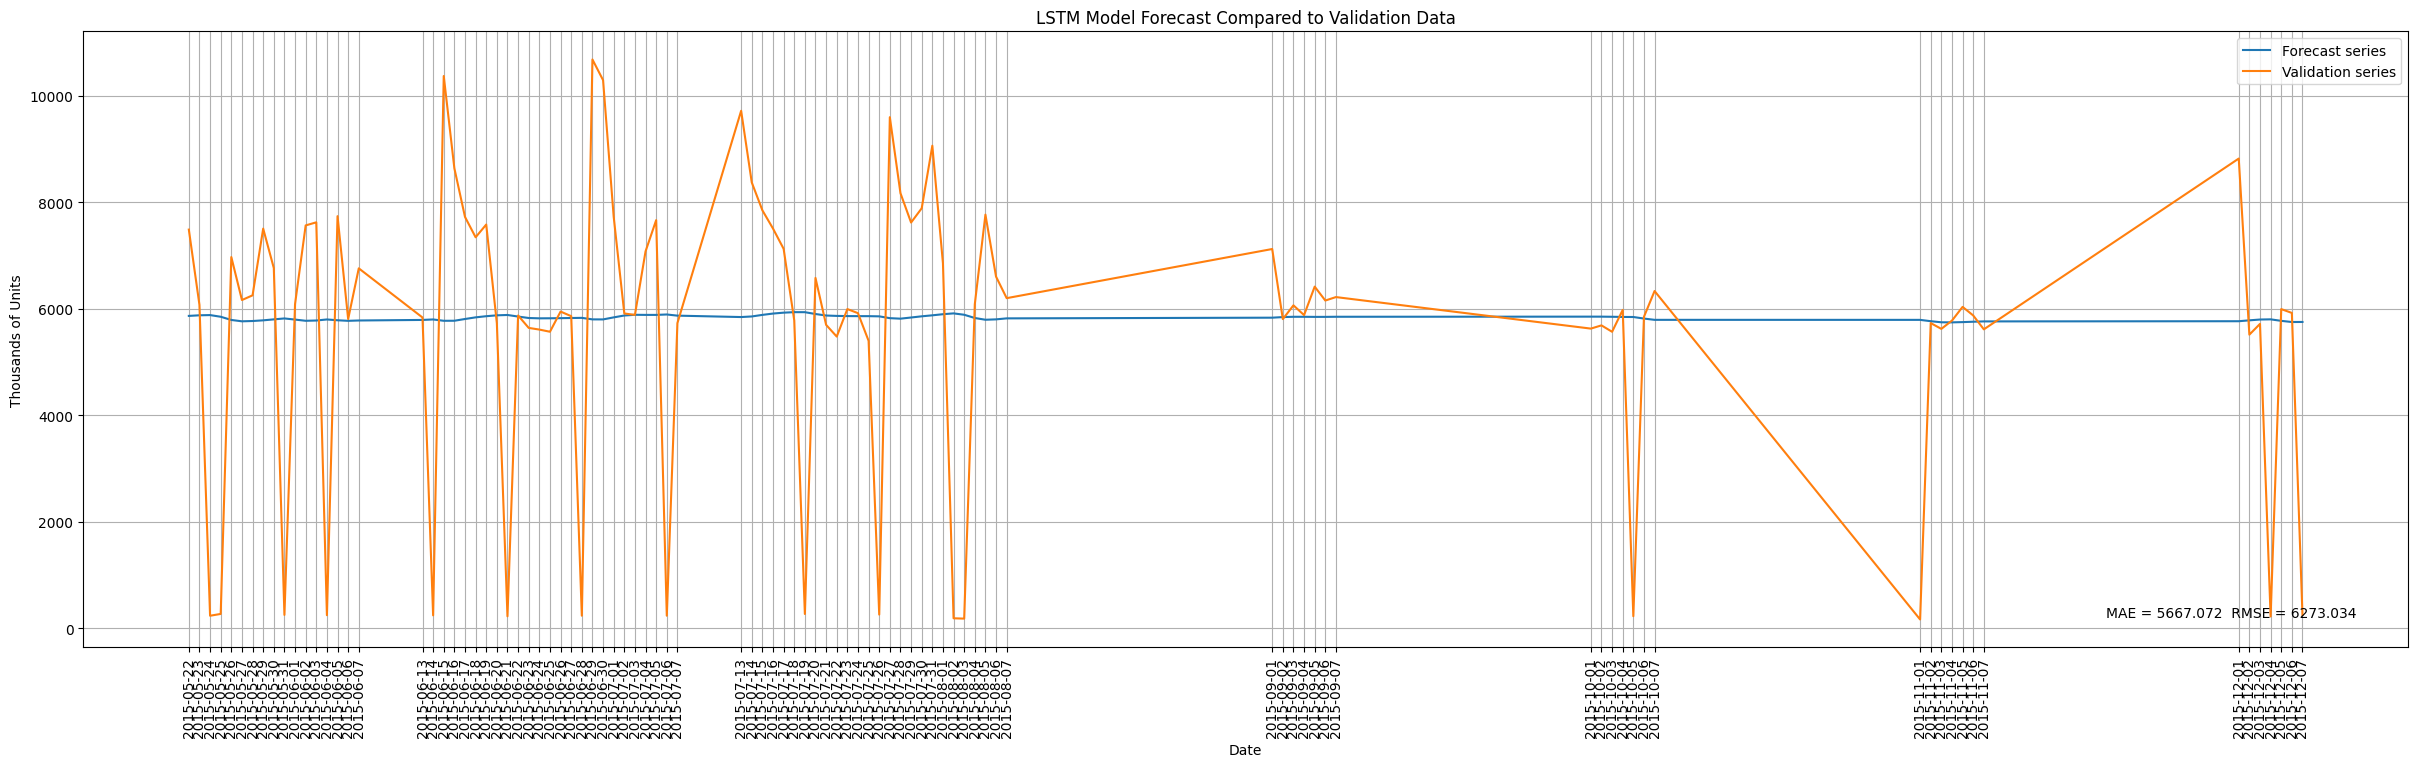

In [108]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [109]:
print(textstr)

MAE = 5667.072  RMSE = 6273.034
